In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from logistic_regression import *

## Sonar

In [3]:
data = pd.read_csv("../../sonar.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [4]:
X = data.loc[:, data.columns[:-1]].values
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
y = data.loc[:, data.columns[-1]]
y = np.where(y == "R", 1, -1)

X = torch.tensor(X)
y = torch.tensor(y)

X.shape, y.shape

(torch.Size([208, 61]), torch.Size([208]))

In [5]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
tau = 1e-3
regression_gd = LogisticRegressionGD(X_train, y_train, tau)
objective = regression_gd.obj

In [7]:
regression_gd.fit(1e-4, max_iter=1000000)

In [8]:
preds = regression_gd.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.8095, dtype=torch.float64)

In [9]:
N = len(regression_gd.log)
N

150684

In [18]:
last_theta = regression_gd.theta.detach().numpy()
last_value = np.min(regression_gd.value_log)

In [11]:
with torch.no_grad():
    avg = regression_gd.log[0].clone()
    avg_log = [avg.clone()]
    avg_value_log = [objective(avg).item()]

    for i in range(2, N+1):
        c = 1. / i
        avg = c * regression_gd.log[i-1] + (1. - c) * avg
        avg_value = objective(avg)
        avg_log.append(avg.clone())
        avg_value_log.append(avg_value)

In [12]:
with torch.no_grad():
    richardson_log = []
    richardson_value_log = []
    for i in range(N):
        theta = 2 * avg_log[i] - avg_log[i//2]
        richardson_log.append(theta)
        richardson_value_log.append(objective(theta).item())

In [14]:
M = 20000

Text(0, 0.5, 'Loss value')

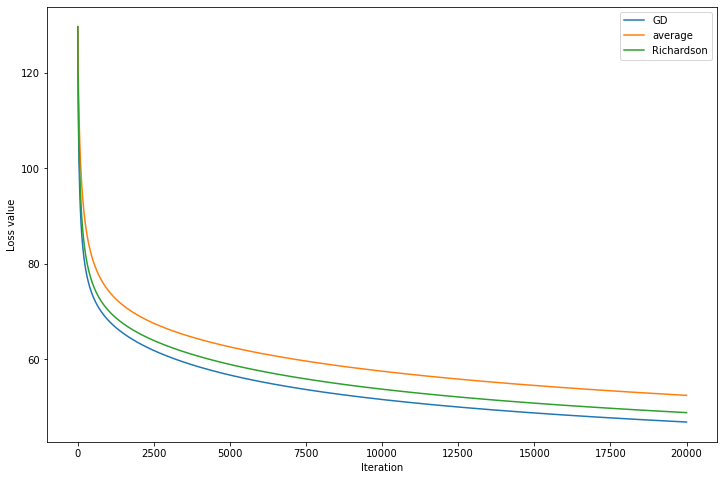

In [19]:
plt.figure(figsize=(12, 8))
x = np.arange(M)
plt.plot(x, regression_gd.value_log[:M], label="GD")
plt.plot(x, avg_value_log[:M], label="average")
plt.plot(x, richardson_value_log[:M], label="Richardson")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")

Text(0, 0.5, '$||x_*-x||_\\infty$')

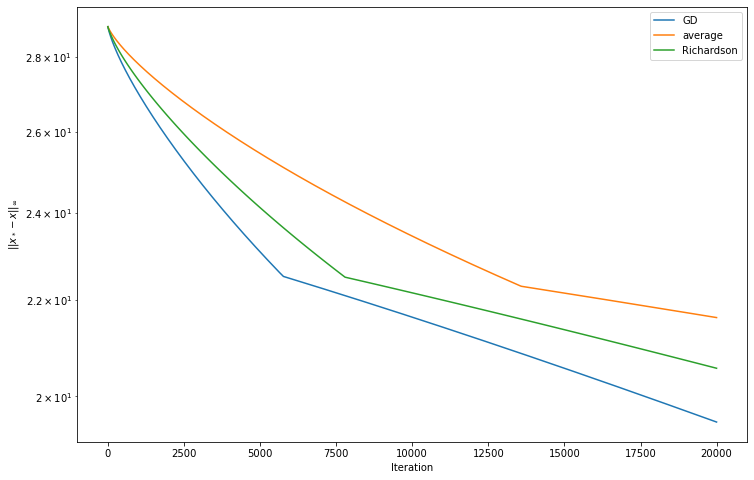

In [20]:
plt.figure(figsize=(12, 8))
x = np.arange(M)
plt.plot(x, [np.max(np.abs(x.detach().numpy() - last_theta)) for x in regression_gd.log[:M]], label="GD")
plt.plot(x, [np.max(np.abs(x.detach().numpy() - last_theta)) for x in avg_log[:M]], label="average")
plt.plot(x, [np.max(np.abs(x.detach().numpy() - last_theta)) for x in richardson_log[:M]], label="Richardson")
plt.yscale("log")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("$||x_*-x||_\infty$")

Text(0, 0.5, '$|f(x_*)-f(x)|$')

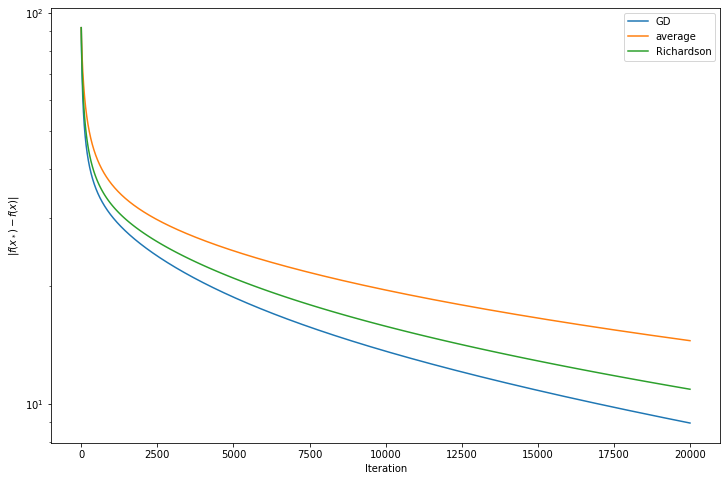

In [21]:
plt.figure(figsize=(12, 8))
x = np.arange(M)
plt.plot(x, np.abs([y - last_value for y in regression_gd.value_log[:M]]), label="GD")
plt.plot(x, np.abs([y - last_value for y in avg_value_log[:M]]), label="average")
plt.plot(x, np.abs([y - last_value for y in richardson_value_log[:M]]), label="Richardson")
plt.legend()
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("$|f(x_*)-f(x)|$")

## Sidi0

In [4]:
device = "cuda"

X = []
with open("../../sido0_train.data") as f:
    for line in f:
        X.append([float(x) for x in line.split()])
X = np.array(X)
X = X[:11000]
X /= X.max()
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
X = torch.tensor(X, device=device)
with open("../../sido0_train.targets") as f:
    y = [int(x) for x in f]
y = y[:11000]
y = torch.tensor(y, device=device)
X.shape, y.shape

(torch.Size([11000, 4933]), torch.Size([11000]))

In [5]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
tau = 1e-3
regression_gd = LogisticRegressionGD(X_train, y_train, tau, device=device)

In [7]:
regression_gd.fit(1e-6, max_iter=100500)

In [13]:
M = 30000

In [9]:
preds = regression_gd.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.9791, device='cuda:0', dtype=torch.float64)

In [10]:
objective = regression_gd.obj
N = len(regression_gd.log)
N

100501

In [27]:
last_theta = regression_gd.theta.cpu().numpy()
last_value = np.min(regression_gd.value_log)

In [15]:
with torch.no_grad():
    avg = regression_gd.log[0].cuda()
    avg_log = [avg.cpu()]
    avg_value_log = [objective(avg).item()]

    for i in tqdm(range(2, M+1)):
        c = 1. / i
        avg = c * regression_gd.log[i-1].cuda() + (1. - c) * avg
        avg_value = objective(avg)
        avg_log.append(avg.cpu())
        avg_value_log.append(avg_value)

In [16]:
len(avg_log)

30000

In [17]:
with torch.no_grad():
    richardson_log = []
    richardson_value_log = []
    for i in range(M):
        theta = 2 * avg_log[i] - avg_log[i//2]
        richardson_log.append(theta)
        richardson_value_log.append(objective(theta.cuda()).item())

Text(0, 0.5, 'Loss value')

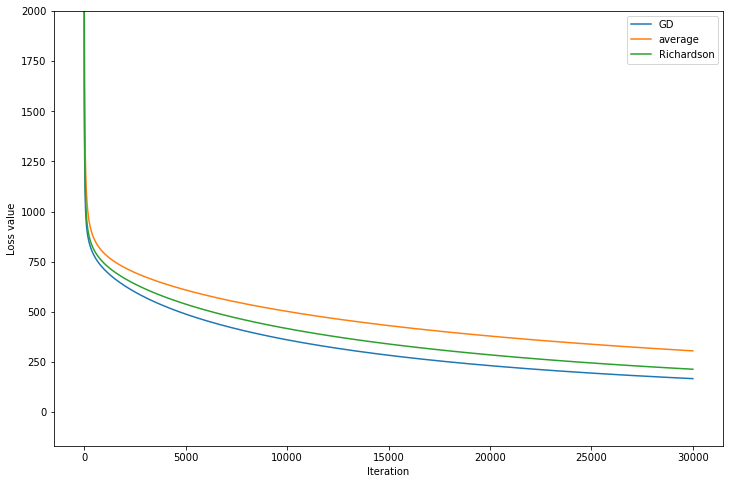

In [23]:
plt.figure(figsize=(12, 8))
x = np.arange(M)
plt.plot(x, regression_gd.value_log[:M], label="GD")
plt.plot(x, avg_value_log[:M], label="average")
plt.plot(x, richardson_value_log[:M], label="Richardson")
plt.legend()
plt.ylim(None, 2000)
plt.xlabel("Iteration")
plt.ylabel("Loss value")

Text(0, 0.5, '$||x_*-x||_\\infty$')

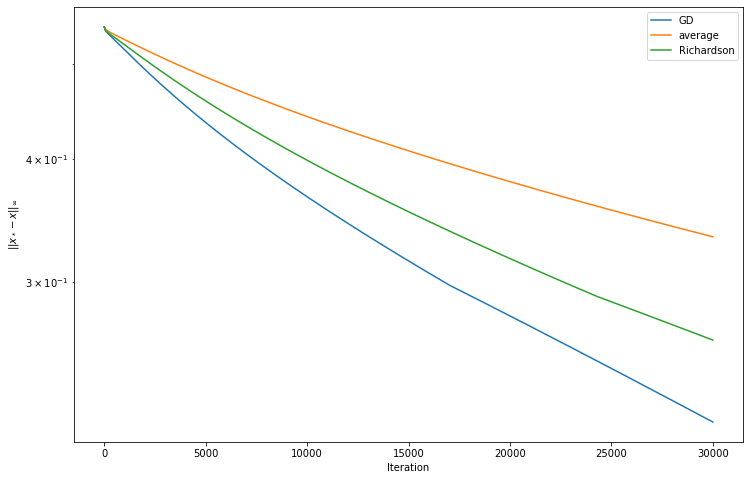

In [25]:
plt.figure(figsize=(12, 8))
x = np.arange(M)
plt.plot(x, [np.max(np.abs(x.detach().numpy() - last_theta)) for x in regression_gd.log[:M]], label="GD")
plt.plot(x, [np.max(np.abs(x.detach().numpy() - last_theta)) for x in avg_log[:M]], label="average")
plt.plot(x, [np.max(np.abs(x.detach().numpy() - last_theta)) for x in richardson_log[:M]], label="Richardson")
plt.yscale("log")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("$||x_*-x||_\infty$")

Text(0, 0.5, '$|f(x_*)-f(x)|$')

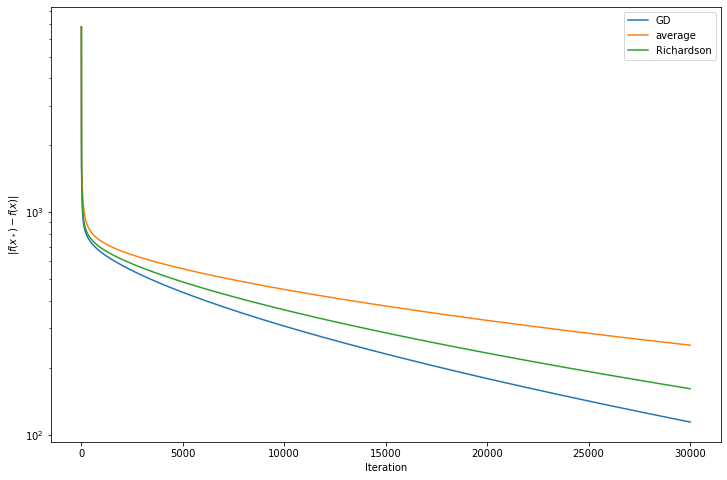

In [28]:
plt.figure(figsize=(12, 8))
x = np.arange(M)
plt.plot(x, np.abs([y - last_value for y in regression_gd.value_log[:M]]), label="GD")
plt.plot(x, np.abs([y - last_value for y in avg_value_log[:M]]), label="average")
plt.plot(x, np.abs([y - last_value for y in richardson_value_log[:M]]), label="Richardson")
plt.legend()
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("$|f(x_*)-f(x)|$")